In [1]:
import pandas as pd
from looper import Looper
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from models import CNN_Encoder, RNN_Decoder_stack_gru, image_features_extract_model

In [2]:
looper = Looper(CNN_Encoder, RNN_Decoder_stack_gru, image_features_extract_model)

Training with the following params:
VOCAB_SIZE : 5000
BATCH_SIZE : 32
BUFFER_SIZE : 5000
embedding_dim : 512
embedding_words : 300
units : 512
embedding_size : 5001
MAX_LENGTH : 20
TOKENIZER_FOLDER : ./tokenizer/
TOKENIZER_NAME : spbe_tokenizer.e
CHECKPOINT_FOLDER : saved_models
## Run set_params to change params ##


In [3]:
tokenizer = looper.load_tokenizer()

loading from ./tokenizer/spbe_tokenizer.e


In [4]:
looper.params

{'VOCAB_SIZE': 5000,
 'BATCH_SIZE': 32,
 'BUFFER_SIZE': 5000,
 'embedding_dim': 512,
 'embedding_words': 300,
 'units': 512,
 'embedding_size': 5001,
 'MAX_LENGTH': 20,
 'TOKENIZER_FOLDER': './tokenizer/',
 'TOKENIZER_NAME': 'spbe_tokenizer.e',
 'CHECKPOINT_FOLDER': 'saved_models'}

In [5]:
# CHANGE PARAMS

params = {'VOCAB_SIZE': 5000,
 'BATCH_SIZE': 64,
 'BUFFER_SIZE': 5000,
 'embedding_dim': 256,
 'embedding_words': 100,
 'units': 512,
 'embedding_size': 5001,
 'MAX_LENGTH': 15,
 'TOKENIZER_FOLDER': './tokenizer/',
 'TOKENIZER_NAME': 'spbe_tokenizer.e',
 'CHECKPOINT_FOLDER': './checkpoint_dis/512_embed_256_units_new_aug_vgg248_stack_max_len_10'}

params = looper.set_params(params)

Training with the following params:
VOCAB_SIZE : 5000
BATCH_SIZE : 64
BUFFER_SIZE : 5000
embedding_dim : 256
embedding_words : 100
units : 512
embedding_size : 5001
MAX_LENGTH : 15
TOKENIZER_FOLDER : ./tokenizer/
TOKENIZER_NAME : spbe_tokenizer.e
CHECKPOINT_FOLDER : ./checkpoint_dis/512_embed_256_units_new_aug_vgg248_stack_max_len_10
## Run set_params to change params ##


In [6]:
looper.load_last_checkpoint()

load from ./checkpoint_dis/512_embed_256_units_new_aug_vgg248_stack_max_len_10/ckpt-19


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe76c3cee80>]],
      dtype=object)

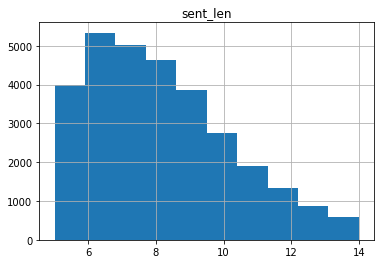

In [7]:
data = pd.read_csv('val.csv')
captions_val = data.title.to_list()
images_val = data.paths.to_list()

data = pd.read_csv('train.csv')
data['captions'] =  data['captions'].astype(str)
data['sent_len'] = data['captions'].apply(lambda r: len(r.split(' ')))
data = data[(data['sent_len']<20) & (data['sent_len']>4)]
captions_train = data.title.to_list()
images_train = data.paths.to_list()
data.hist('sent_len')

In [8]:
looper.make_tokenizer(captions_train,text_file_name='titles_v2.txt')
looper.load_tokenizer()

loading from ./tokenizer/spbe_tokenizer.e


Tokenizer(vocabulary_size=5000, model=SentencePieceBPE, unk_token=<unk>, replacement=▁, add_prefix_space=True, dropout=None)

In [9]:
looper.params['MAX_LENGTH']

15

In [10]:
dataset_val = looper.make_dataset(images_val,captions_val)

max title len 15
len titles: 1991,len images: 1991
captions vector shape (1991, 15)
NOT using augmentations in loader


In [11]:
dataset_train = looper.make_dataset(images_train, captions_train, loader_type='aug')

max title len 15
len titles: 24350,len images: 24350
captions vector shape (24350, 15)
Using augmentations in loader


In [12]:
looper.train(dataset_train, dataset_val, 40, save_n=3)

Epoch 1 Batch 0 Loss 0.0863
Epoch 1 Batch 100 Loss 0.0688
Epoch 1 Batch 200 Loss 0.0698


KeyboardInterrupt: 

In [74]:
def plot_losses(plot):
    f, ax = plt.subplots(1,2, figsize=(12,4))
    
    ax[0].plot([i['epoch'] for i in plot], [i['val'] for i in plot], c = 'k', label='val pr')
    ax[0].plot([i['epoch'] for i in plot], [i['train'] for i in plot], c ='g', label='train pr')
    ax[1].plot([i['epoch'] for i in plot], [i['val_loss'] for i in plot], c = 'k', label='val loss')
    ax[1].plot([i['epoch'] for i in plot], [i['train_loss'] for i in plot], c ='g', label='train loss')
    ax[0].legend(loc="upper left")
    ax[1].legend(loc="upper left")

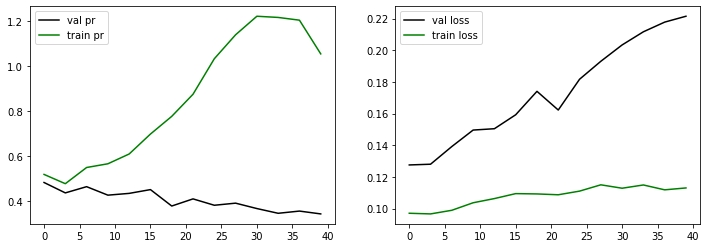

In [75]:
plot_losses(looper.plot)

# CHECK VAL

Real Caption: how to get some answers out of the goddamn fish
0.5, how to grow facial put in parasia , score 2
0.7, how to get your step 15 years alone , score 3
0.9, how to roll your operatee in your shirt , score 2
1, how to find out what you preform fellatio , score 3


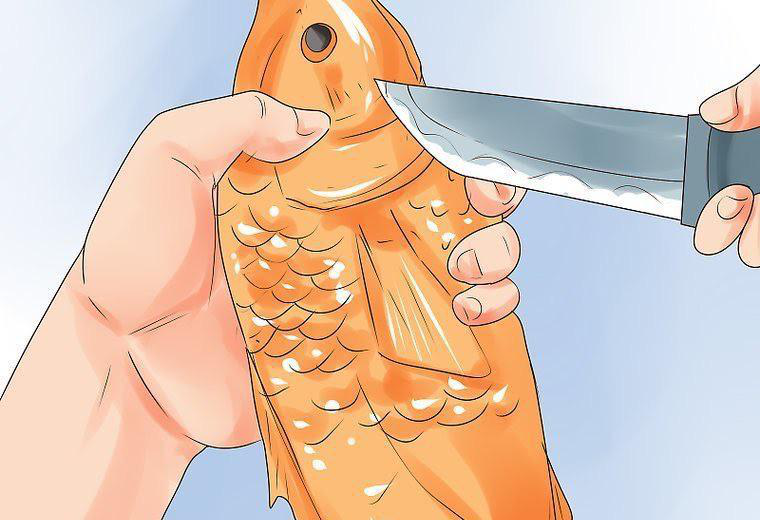

In [186]:
#### captions on the validation set

#img_name_val, cap_val
rid = np.random.randint(0, len(captions_val))
image = images_val[rid] #'./img.jpg' #
real_caption = captions_val[rid]
print ('Real Caption:', real_caption)

at_k = 5 # use 5 first words to compute score
seed = None #'▁cat'

for t in [0.5,0.7,0.9,1]:
    predicted_ids, a = looper.predict_one(image, t, argmax =2, seed=seed)
    real_cap = set(real_caption.split(' '))
    predicted_cap =  looper.tokenizer.decode(predicted_ids)
    score = len(real_cap.intersection(set(predicted_cap.split(' ')[:at_k]))) #/len(word)
    print(f"{t}, {predicted_cap}, score {score}")
Image.open(image)


0.5, how to swim with cold shower , score 2
0.7, how to swim with swim , score 2
0.9, how to swim with the children fly , score 3
1, how to swim with swimman relig predator productman relig predator productout the, score 2


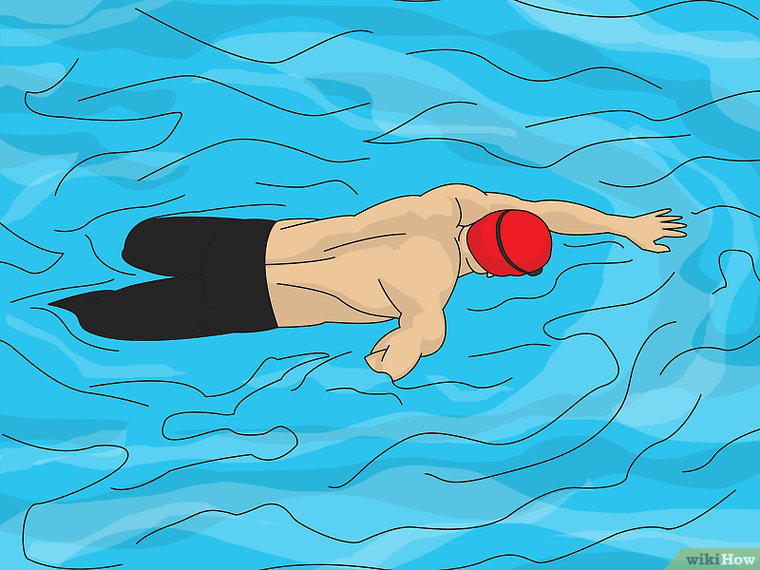

In [153]:
#### captions on the validation set

#img_name_val, cap_val
#rid = np.random.randint(0, len(captions_val))
image =  './img.jpg' #images_val[rid]
#real_caption = captions_val[rid]
#print ('Real Caption:', real_caption)

at_k = 5 # use 5 first words to compute score
seed = None #   '▁nice' 

for t in [0.5,0.7,0.9,1]:
    predicted_ids, a = looper.predict_one(image, t, argmax =2, seed=seed)
    real_cap = set(real_caption.split(' '))
    predicted_cap =  looper.tokenizer.decode(predicted_ids)
    score = len(real_cap.intersection(set(predicted_cap.split(' ')[:at_k]))) #/len(word)
    print(f"{t}, {predicted_cap}, score {score}")
Image.open(image)

### CHECK TRAIN

Real Caption: how to start your bead collection
0.5, how to prepare your cat direct , score 3
0.7, how to oper fill out your cat , score 2
0.9, how to crush your dog , score 3
1, how to collect fish eyes. , score 2


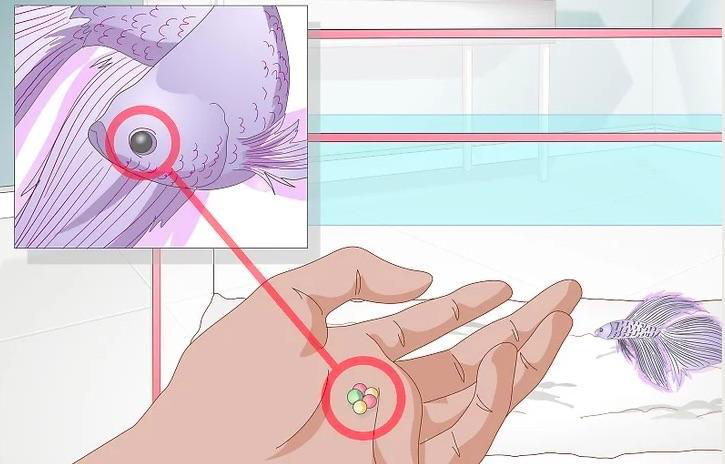

In [169]:
#### captions on the validation set

#img_name_val, cap_val
rid = np.random.randint(0, len(captions_train))
image = images_train[rid] #'./img.jpg' #
real_caption = captions_train[rid]
print ('Real Caption:', real_caption)

at_k = 5 # use 5 first words to compute score
seed = None #'▁cat'

for t in [0.5,0.7,0.9,1]:
    predicted_ids, a = looper.predict_one(image, t, argmax =2, seed=seed)
    real_cap = set(real_caption.split(' '))
    predicted_cap =  looper.tokenizer.decode(predicted_ids)
    score = len(real_cap.intersection(set(predicted_cap.split(' ')[:at_k]))) #/len(word)
    print(f"{t}, {predicted_cap}, score {score}")
Image.open(image)